In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")

print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *
cc_df = pd.read_csv("../data/drug_CC.csv")

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

#solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")
drugs_lst = os.listdir(analysis_dir)

# do after canetti replacement above because there are commas in them
single_lineages = lineages.query("~Lineage.str.contains(',')").reset_index(drop=True)
print(single_lineages.shape)

who_variants = pd.read_csv("../results/WHO-catalog-V2.csv", header=[2]).query("tier==1").reset_index(drop=True)
del who_variants['mutation']

results_final = pd.read_csv("../results/Regression_Final_Jan2024_Tier1.csv")
# results_final = pd.read_csv("../results/Regression_Final_Nov2023_Tier1.csv")

# removes the inframe variants
# results_final = results_final.merge(who_variants[['drug', 'variant', 'INITIAL CONFIDENCE GRADING']].rename(columns={'drug': 'Drug', 'variant': 'mutation', 'INITIAL CONFIDENCE GRADING': 'SOLO INITIAL CONFIDENCE GRADING'}), on=['Drug', 'mutation'], how='right')

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")
additional_samples = pd.read_excel("../data/additional_samples.xlsx", sheet_name=None)['Query result'] # only one sheet
missing_28samples = pd.read_excel("../data/missing_28samples.xlsx", sheet_name=None)['Query result'] # only one sheet
missing_coll2014_8samples = pd.read_csv("../data/missing_coll2014_8samples.csv")

samples_summary = pd.read_csv("../data/samples_summary.csv")

(52567, 10)
(52164, 10)


FileNotFoundError: [Errno 2] No such file or directory: '../data/additional_samples.xlsx'

# Isolate and Variant Counts for each Model (16 drugs x 9 models = 144): Table S4

In [107]:
model_sizes = pd.DataFrame(columns = ['Drug', 'Phenotypes', 'Model', 'Isolates', 'Variants'])
i = 0

model_name_mapping = {'dropAF_noSyn_unpooled': 'Unpooled,-Silent',
                      'dropAF_noSyn_poolSeparate': 'Pooled,-Silent',
                      'dropAF_withSyn_unpooled': 'Unpooled,+Silent'
                     }

pheno_name_mapping = {'BINARY/tiers=1/phenos=WHO': 'WHO',
                      'BINARY/tiers=1/phenos=ALL': 'ALL',
                      'MIC/tiers=1': 'MIC'
                     }

for drug in drugs_lst:

    for phenos in ['BINARY/tiers=1/phenos=WHO', 'BINARY/tiers=1/phenos=ALL', 'MIC/tiers=1']:

        for model in ['dropAF_noSyn_unpooled', 'dropAF_noSyn_poolSeparate', 'dropAF_withSyn_unpooled']:

            model_fName = os.path.join(analysis_dir, drug, phenos, model, "model_matrix.pkl")
            
            if os.path.isfile(model_fName):
                model_matrix = pd.read_pickle(model_fName)

                # if 'withSyn' in model:
                #     noSyn_model = pd.read_pickle(os.path.join(analysis_dir, drug, phenos, model.replace('withSyn', 'noSyn'), "model_matrix.pkl"))
                #     num_variants = len(set(model_matrix.columns) - set(noSyn_model.columns))
                # else:
                #     num_variants = model_matrix.shape[1]
                num_variants = model_matrix.shape[1]
                    
                model_sizes.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], model_matrix.shape[0], num_variants]
            # Pretomanid/ALL models and some pooled models do not exist
            else:
                model_sizes.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], np.nan, np.nan]

            i += 1

model_sizes.sort_values(['Drug', 'Phenotypes'], ascending=[True, False]).to_csv("../supplement/model_input_sizes.csv", index=False)

# Numbers of Isolates and Variants dropped from each model: Table 4

In [25]:
isolates_variants_dropped_df = pd.DataFrame(columns = ['Drug', 'Phenotypes', 'Model', 'Isolates_Amb', 'Variants_Amb', 'Isolates_Missing', 'Variants_Missing'])
i = 0

model_name_mapping = {'dropAF_noSyn_unpooled': 'Unpooled,-Silent',
                      'dropAF_noSyn_poolSeparate': 'Pooled,-Silent',
                      'dropAF_withSyn_unpooled': 'Unpooled,+Silent'
                     }

pheno_name_mapping = {'BINARY/tiers=1/phenos=WHO': 'WHO',
                      'BINARY/tiers=1/phenos=ALL': 'ALL',
                     }

for drug in drugs_lst:

    for phenos in ['BINARY/tiers=1/phenos=WHO', 'BINARY/tiers=1/phenos=ALL']:

        for model in ['dropAF_noSyn_unpooled']:#, 'dropAF_noSyn_poolSeparate', 'dropAF_withSyn_unpooled']:

            if os.path.isdir(os.path.join(analysis_dir, drug, phenos, model)):
                
                isolates_missing_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_isolates/isolates_dropped.txt")
                isolates_amb_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_isolates/isolates_with_amb.txt")

                variants_missing_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_features/isolates_dropped.txt")
                variants_amb_fName = os.path.join(analysis_dir, drug, phenos, model, "dropped_features/isolates_with_amb.txt")
                
                if os.path.isfile(isolates_missing_fName):
                    num_isolates_missing = len(pd.read_csv(isolates_missing_fName, sep='\t', header=None))
                else:
                    num_isolates_missing = 0
    
                if os.path.isfile(isolates_amb_fName):
                    num_isolates_amb = len(pd.read_csv(isolates_amb_fName, sep='\t', header=None))
                else:
                    num_isolates_amb = 0

                if os.path.isfile(variants_missing_fName):
                    num_variants_missing = len(pd.read_csv(variants_missing_fName, sep='\t', header=None))
                else:
                    num_variants_missing = 0
    
                if os.path.isfile(variants_amb_fName):
                    num_variants_amb = len(pd.read_csv(variants_amb_fName, sep='\t', header=None))
                else:
                    num_variants_amb = 0

                isolates_dropped_df.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], num_isolates_amb, num_variants_amb, num_isolates_missing, num_variants_missing]
                
            else:
                isolates_dropped_df.loc[i, :] = [drug, pheno_name_mapping[phenos], model_name_mapping[model], np.nan, np.nan, np.nan, np.nan]

            i += 1

# isolates_dropped_df.sort_values(['Drug', 'Phenotypes'], ascending=[True, False])

In [44]:
# for i, row in lineages_new.iterrows():

#     if not pd.isnull(row['Coll2014']):

#         if ',' not in row['Coll2014']:
#             if row['Coll2014'][0].isnumeric():
#                 lineages_new.loc[i, 'Lineage'] = row['Coll2014'][0]
#             else:
#                 lineages_new.loc[i, 'Lineage'] = row['Coll2014']

#         else:
#             primary_lineages = []
#             split_lineages_lst = row['Coll2014'].split(',')

#             for single_lineage in split_lineages_lst:
                
#                 if single_lineage[0].isnumeric():
#                     primary_lineages.append(single_lineage[0])
#                 else:
#                     primary_lineages.append(single_lineage)

#             lineages_new.loc[i, 'Lineage'] = ','.join(np.sort(np.unique(primary_lineages)))
    
#     else:
#         lineages_new.loc[i, 'Lineage'] = row['Lipworth2019']

In [2]:
# # get single lineage (highest level) from the Coll2014 scheme

# if 'Lineage' in lineages.columns:
#     del lineages['Lineage']
    
# missing_coll2014_8samples_lineage_dict = dict(zip(missing_coll2014_8samples['Sample_Name'], missing_coll2014_8samples['Lineage']))

# for i, row in lineages.iterrows():

#     if not pd.isnull(row['Coll2014']):
#         if ',' not in row['Coll2014']:
#             if row['Coll2014'][0].isnumeric():
#                 lineages.loc[i, 'Lineage'] = row['Coll2014'][0]
#             else:
#                 lineages.loc[i, 'Lineage'] = row['Coll2014']
#         else:
#             clean_lineage = []

#             for single_lineage in row['Coll2014'].split(','):
#                 if single_lineage[0].isnumeric():
#                     clean_lineage.append(single_lineage[0])
#                 else:
#                     clean_lineage.append(single_lineage)
                    
#             lineages.loc[i, 'Lineage'] = ','.join(np.unique(clean_lineage)) 

#     else:
#         # need to get the Lipworth 2019 lineage
#         if row['Sample_Name'] not in list(missing_coll2014_8samples_lineage_dict.keys()):
#             print(f"{row['Sample_Name']} is missing lineage information")
#         else:
#             lineages.loc[i, 'Lineage'] = missing_coll2014_8samples_lineage_dict[row['Sample_Name']]

# lineages.shape, lineages.Sample_ID.nunique(), lineages.Sample_Name.nunique(), len(lineages.loc[pd.isnull(lineages['Lineage'])])

# 0. Correlations Between Lineages and Each PC

In [9]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                   "BOV": "gray",
                   "BOV_AFRI": "black",
                  }

def plot_PCA_colored_by_lineage(lineage_df, eigenvec_df, pc_x, pc_y, include_lineages=None, color_col="Lineage", legend_out=False, color_dict=None, saveName=None):

    if include_lineages is None:
        include_lineages = lineage_df.Lineage.unique()
        color_col = "Lineage"
        color_dict = LinToColor_Dict
    else:
        color_dict = None
        
    plot_df = lineage_df.query("Lineage in @include_lineages").merge(eigenvec_df, left_on="Sample_ID", right_index=True, how="inner")

    # remove isolates that don't have a subgroup
    if color_col != 'Lineage':
        plot_df = plot_df.query("Coll2014 not in @include_lineages").sort_values(color_col, ascending=True)
        
    fig, ax = plt.subplots(figsize=(5, 4))
    
    if color_dict is None:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        #palette=Category20[20],
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )
    else:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        hue_order=np.sort(include_lineages),
                        palette=color_dict,
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )

    plt.title(f"{plot_df.Sample_ID.nunique()} Isolates")
    
    # if legend_out:
    #     sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))
    # else:
    #     sns.move_legend(ax, fontsize=8, title='', loc='best')

    # for lh in ax._legend.legendHandles: 
    #     lh._sizes = [10] 
    #     # You can also use lh.set_sizes([50])

    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

In [4]:
scaler = StandardScaler()

combined_single_lineage_PC = pd.get_dummies(single_lineages.set_index("Sample_ID")["Lineage"]).astype(int).merge(eigenvec_df, left_index=True, right_index=True)

def get_lineage_correlations_with_PC(lineage, sig_thresh=0.01):

    single_lineage_pvals = pd.DataFrame(columns=["rho", "pval", "PC", "abs_rho"])
    
    for i, col in enumerate(combined_single_lineage_PC.columns[combined_single_lineage_PC.columns.str.contains("PC")]):
    
        # rho, pval = st.pointbiserialr(combined_single_lineage_PC[lineage].values, combined_single_lineage_PC[col].values)
        rho, pval = st.pearsonr(np.squeeze(scaler.fit_transform(combined_single_lineage_PC[lineage].values.reshape(-1, 1))), 
                                combined_single_lineage_PC[col].values
                               )
        
        single_lineage_pvals.loc[i, :] = [rho, pval, int(col.replace("PC", "")), np.abs(rho)]
    
    single_lineage_pvals["Bonferroni_pval"] = np.min([single_lineage_pvals["pval"] * len(single_lineage_pvals), np.ones(len(single_lineage_pvals))], axis=0)
    return single_lineage_pvals.query("Bonferroni_pval < @sig_thresh").sort_values("abs_rho", ascending=False)

In [11]:
lineage_corr_dict = {}

for lineage in np.sort(single_lineages.Lineage.unique()):

    num_lineage = len(single_lineages.query("Lineage==@lineage"))
    
    if num_lineage / len(single_lineages) >= 0.005:
        lineage_corr_dict[lineage] = get_lineage_correlations_with_PC(lineage)

In [16]:
lineages.query("Lineage.str.contains(',')").Lineage.value_counts()

Lineage
2,4             141
6,BOV_AFRI       72
3,4              51
1,4              46
1,2              37
2,3              26
1,3              12
4,BOV_AFRI        3
2,BOV_AFRI        2
4,5               2
4,7               1
2,6,BOV_AFRI      1
1,2,3             1
Name: count, dtype: int64

In [26]:
len(single_lineages) / len(lineages)

0.992485780052124

In [28]:
len(lineages.query("Lineage.str.contains(',')"))/len(lineages)

0.007514219947876044

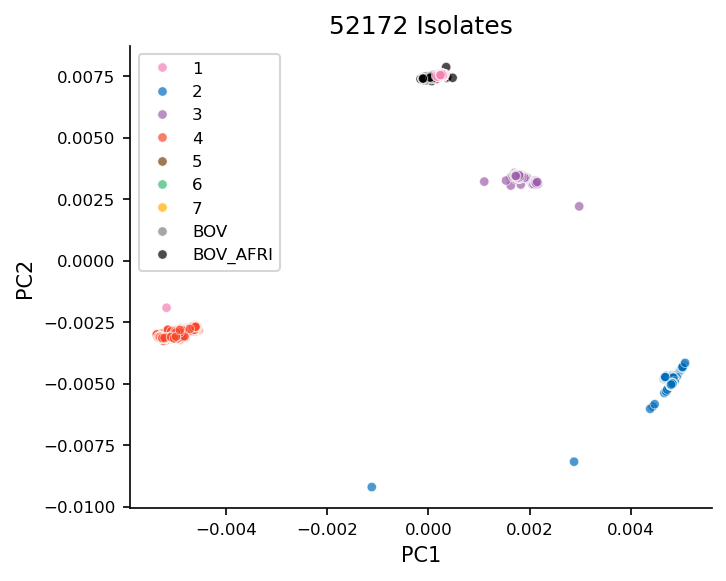

In [20]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC1', pc_y='PC2', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC1_PC2.png'
                           )

In [25]:
52172/len(lineages)

0.992485780052124

52567

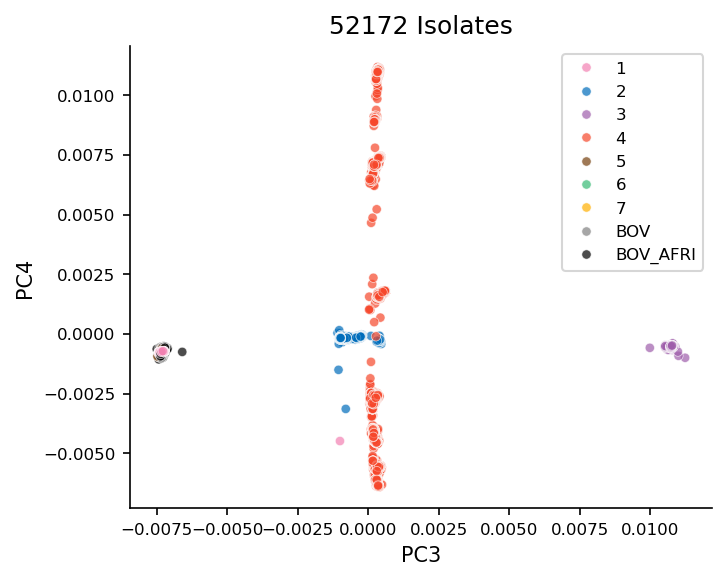

In [21]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC3', pc_y='PC4', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC3_PC4.png'
                           )

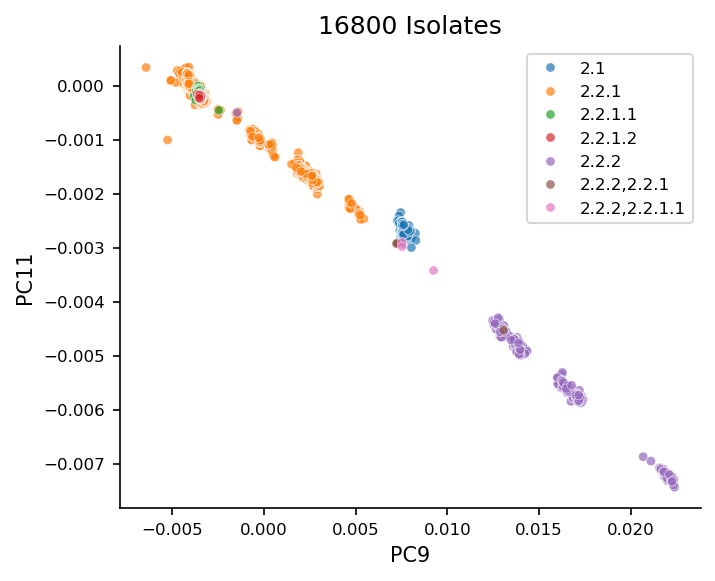

In [22]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC11', 
                            include_lineages=["2"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC9_PC11_L2.png'
                           )

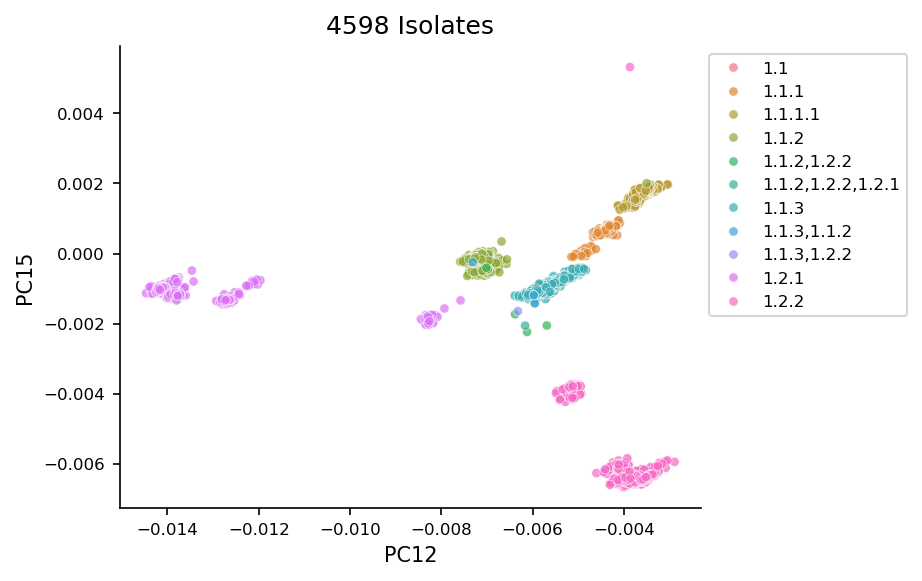

In [25]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC15', 
                            include_lineages=["1"],
                            color_col="Coll2014", 
                            legend_out=True,
                            color_dict=LinToColor_Dict, 
                            saveName='../PCA/PC12_PC15_L1.png'
                           )

# 1. Numbers of Isolates and Variants in Each Model

In [367]:
summary_df = pd.DataFrame(columns = ['Drug', 'WHO_Isolates_Base', 'WHO_Unpooled_Variants', 'WHO_Pooled_Variants', 'WHO_Silent_Only', 'ALL_Isolates_Base', 'ALL_Unpooled_Variants', 'ALL_Pooled_Variants', 'ALL_Silent_Only'])
i = 0

for drug in drugs_lst:

    who_nonsilent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
    
    try:
        who_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_poolSeparate", "model_matrix.pkl"))
    except:
        who_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
    
    who_silent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=WHO", "dropAF_withSyn_unpooled", "model_matrix.pkl"))

    who_silent_variants = set(who_silent.columns) - set(who_nonsilent.columns)
    
    if drug != 'Pretomanid':
        all_nonsilent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
        
        try:
            all_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_poolSeparate", "model_matrix.pkl"))
        except:
            all_nonsilent_pooled = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_noSyn_unpooled", "model_matrix.pkl"))
        
        all_silent = pd.read_pickle(os.path.join(analysis_dir, drug, "BINARY", "tiers=1", "phenos=ALL", "dropAF_withSyn_unpooled", "model_matrix.pkl"))
        
    else:
        all_nonsilent = pd.DataFrame()
        all_nonsilent_pooled = pd.DataFrame()
        all_silent = pd.DataFrame()

    all_silent_variants = set(all_silent.columns) - set(all_nonsilent.columns)

    summary_df.loc[i, :] = [drug, who_nonsilent.shape[0], who_nonsilent.shape[1], who_nonsilent_pooled.shape[1], len(who_silent_variants),
                            all_nonsilent.shape[0], all_nonsilent.shape[1], all_nonsilent_pooled.shape[1], len(all_silent_variants)]
    i += 1

summary_df = summary_df.sort_values("Drug", ascending=True).reset_index(drop=True)
summary_df.to_csv("../data/model_input_sizes.csv", index=False)

In [368]:
summary_df

,Drug,WHO_Isolates_Base,WHO_Unpooled_Variants,WHO_Pooled_Variants,WHO_Silent_Only,ALL_Isolates_Base,ALL_Unpooled_Variants,ALL_Pooled_Variants,ALL_Silent_Only
0,Amikacin,8454,272,251,30,23614,646,609,74
1,Bedaquiline,2012,223,164,31,13861,620,516,193
2,Capreomycin,9534,256,206,19,16956,432,368,34
3,Clofazimine,4916,366,310,112,14690,813,702,276
4,Delamanid,571,64,57,34,11594,489,475,271
5,Ethambutol,32267,2379,2368,1034,44180,2862,2848,1231
6,Ethionamide,5890,674,492,75,20444,1306,971,238
7,Isoniazid,34585,1337,1224,292,48246,1686,1535,371
8,Kanamycin,7553,282,262,24,23494,670,634,75
9,Levofloxacin,12200,436,436,283,27108,801,800,567


# 2. Numbers of R and S Isolates in each Model

In [114]:
def compute_number_of_isolates_per_model(drug, phenos_name, tiers_lst):

    fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
    
    if os.path.isfile(fName):
        model_matrix = pd.read_pickle(fName)

        samples = model_matrix.index.values
        del model_matrix

        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query("sample_id in @samples")    
        return len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))
    else:
        return np.nan, np.nan

In [115]:
RS_counts = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):

    if drug != 'Pretomanid':
        num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1"])
        num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1"])
        
        RS_counts.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

# Calculate percentages for stacking
RS_counts['WHO_Percent_R'] = RS_counts['WHO_Num_R'] / (RS_counts['WHO_Num_R'] + RS_counts['WHO_Num_S']) * 100
RS_counts['WHO_Percent_S'] = RS_counts['WHO_Num_S'] / (RS_counts['WHO_Num_R'] + RS_counts['WHO_Num_S']) * 100

RS_counts['ALL_Percent_R'] = RS_counts['ALL_Num_R'] / (RS_counts['ALL_Num_R'] + RS_counts['ALL_Num_S']) * 100
RS_counts['ALL_Percent_S'] = RS_counts['ALL_Num_S'] / (RS_counts['ALL_Num_R'] + RS_counts['ALL_Num_S']) * 100

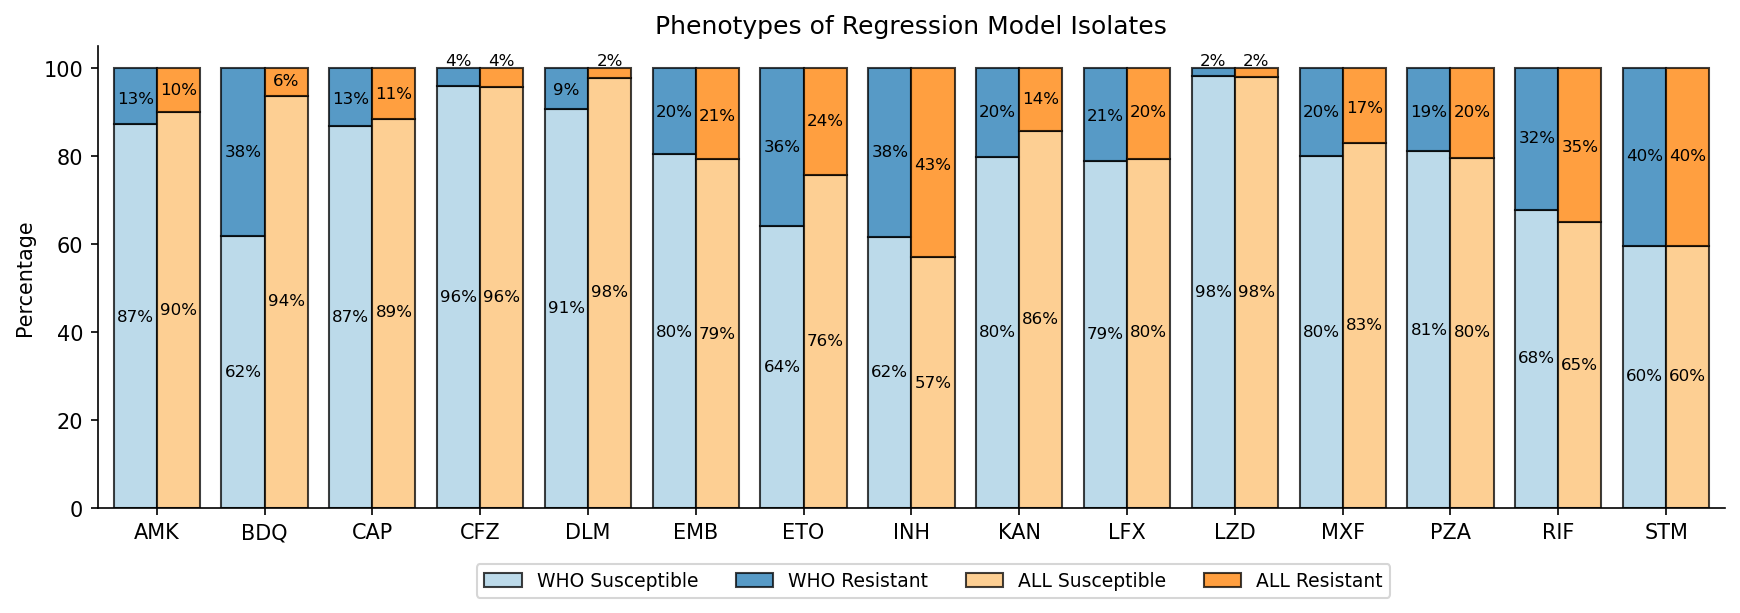

In [116]:
# Plotting
bar_width=0.4
fig, ax = plt.subplots(figsize=(14, 4))
colors = sns.color_palette('Paired').as_hex()[:2] + sns.color_palette('Paired')[6:8]

ax.bar(np.arange(len(RS_counts['Drug'])) - bar_width/2, RS_counts['WHO_Percent_S'], label='WHO Susceptible', width=bar_width, color=colors[0], edgecolor='black', alpha=0.75)
ax.bar(np.arange(len(RS_counts['Drug'])) - bar_width/2, RS_counts['WHO_Percent_R'], label='WHO Resistant', bottom=RS_counts['WHO_Percent_S'], width=bar_width, color=colors[1], edgecolor='black', alpha=0.75)

ax.bar(np.arange(len(RS_counts['Drug'])) + bar_width/2, RS_counts['ALL_Percent_S'], label='ALL Susceptible', width=bar_width, color=colors[2], edgecolor='black', alpha=0.75)
ax.bar(np.arange(len(RS_counts['Drug'])) + bar_width/2, RS_counts['ALL_Percent_R'], label='ALL Resistant', bottom=RS_counts['ALL_Percent_S'], width=bar_width, color=colors[3], edgecolor='black', alpha=0.75)

# Add labels to each bar
for drug in RS_counts['Drug']:

    plot_vals = RS_counts.loc[RS_counts['Drug']==drug, ['WHO_Percent_S', 'WHO_Percent_R', 'ALL_Percent_S', 'ALL_Percent_R']]
    
    for col in plot_vals.columns:
        
        if 'WHO' in col:
            x_pos = list(RS_counts['Drug']).index(drug) - bar_width/2
            
        else:
            x_pos = list(RS_counts['Drug']).index(drug) + bar_width/2

        val = int(np.round(plot_vals[col].values[0], 0))

        if not pd.isnull(val):

            associated_count = RS_counts.set_index('Drug').loc[drug, col.replace('Percent', 'Num')]
            # combined_text = f"{val}%\n({'{:,.0f}'.format(associated_count)})"
            combined_text = f"{val}%"

            if 'S' in col:
                y_pos = val / 2
            else:
                y_pos = int((100 - val) + val / 2)

            # small numbers for which the bars are too short to accommodate the whole number, put on top
            if val < 5:                
                ax.text(x_pos, 100, combined_text, ha='center', va='bottom', fontsize='8')
            else:
                ax.text(x_pos, y_pos, combined_text, ha='center', va='center', fontsize='8')

ax.set_xticks(ticks=np.arange(len(RS_counts['Drug'])), labels=[drug_abbr_dict[drug] for drug in RS_counts['Drug']])
ax.set_ylabel('Percentage')
ax.set_title('Phenotypes of Regression Model Isolates')
sns.despine()
ax.legend()
ax.margins(x=0.01)
sns.move_legend(ax, ncols=4, fontsize=9, title='', loc='best', bbox_to_anchor=(0.8, -0.1))
plt.savefig("../results/Figures/phenos_breakdown.png", dpi=300, bbox_inches="tight")

# 3. Lineage Breakdown for Each Drug

In [36]:
def create_lineage_summary_df(og_lineages_df, other_thresh=0.01):
    '''
    other_cols is a list of lineages that should be combined into an other category because there are so few of them. Basically just for aesthetic purposes
    '''
    
    lineage_summary = pd.DataFrame(og_lineages_df["Lineage"].value_counts()).reset_index()
    
    # get lineages that are present at < 1% frequency. Combine them into an "Other" category for aesthetic purposes in plotting
    samples_total = lineage_summary["count"].sum()
    samples_thresh = int(other_thresh*samples_total)
    other_cols = lineage_summary.query("count < @samples_thresh")["Lineage"].values
    
    # ",".join(other_cols) --> this makes the name too long, but can try later
    # combine low-frequency lineages into an Other category
    lineage_summary = pd.concat([lineage_summary, 
                                 pd.DataFrame({"Lineage": "Other", "count": lineage_summary.query("Lineage in @other_cols")["count"].sum()
                                              }, index=[-1])
                                ]).query("Lineage not in @other_cols")
    
    lineage_summary = lineage_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    lineage_summary["count"] = lineage_summary["count"].astype(int)
    return lineage_summary

In [37]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:

        if drug != 'Pretomanid':
            fName = os.path.join(analysis_dir, drug, "BINARY", "tiers=1/phenos=ALL", "dropAF_noSyn_unpooled/model_matrix.pkl")
        else:
            fName = os.path.join(analysis_dir, drug, "BINARY", "tiers=1/phenos=WHO", "dropAF_noSyn_unpooled/model_matrix.pkl")
        
        model_matrix = pd.read_pickle(fName)
        samples = model_matrix.index.values
    
        single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("Sample_ID in @samples"), other_thresh=0.01)
        single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

        lineage_summaries_by_drug.append(single_drug_lineage_summary)
    
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [38]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)
single_drug_lineage_summary

,Lineage,count,Drug
0,1,1701,LFX
1,2,10942,LFX
2,3,2456,LFX
3,4,11774,LFX
4,Other,74,LFX
...,...,...,...
0,1,1310,ETO
1,2,7807,ETO
2,3,2019,ETO
3,4,9134,ETO


In [110]:
def create_stacked_percent_bar_chart(df, xvar, quantVar, hueVar, saveName=None):
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "Other": "white"
                      }
    
    # set the figure size
    fig, ax = plt.subplots(figsize=(12, 4))
    font_size = '7'
    
    df = df.query("Drug != 'PMD'")

    lineage_stacked_for_plotting_counts = df.pivot(index="Drug", columns="Lineage", values="count")
    lineage_stacked_for_plotting_counts["Total"] = lineage_stacked_for_plotting_counts.sum(axis=1)
    lineage_stacked_for_plotting_counts = lineage_stacked_for_plotting_counts.fillna(0)
    lineage_stacked_for_plotting = lineage_stacked_for_plotting_counts.copy()

    # compute proportions for plotting
    for lineage in df["Lineage"].unique():
        lineage_stacked_for_plotting[lineage] = lineage_stacked_for_plotting[lineage] / lineage_stacked_for_plotting["Total"] * 100
        
    del lineage_stacked_for_plotting["Total"]
        
    # keep track of all the groups to increase the start value of the next bar
    prev_vals_array = np.zeros(len(lineage_stacked_for_plotting))

    # reverse order of the numerical lineages so that L1 is at the top and L4 is at the bottom
    # need to put non-numerical lineages at the end (after L1) to be at the top
    color_groups = np.concatenate([np.sort([col for col in lineage_stacked_for_plotting.columns if col.isnumeric()])[::-1], [col for col in lineage_stacked_for_plotting.columns if not col.isnumeric()]])

    # reorder the dataframes to that order too
    lineage_stacked_for_plotting = lineage_stacked_for_plotting[color_groups]
    lineage_stacked_for_plotting_counts = lineage_stacked_for_plotting_counts[color_groups]
    
    drugs_lst = lineage_stacked_for_plotting_counts.index.values
    
    for i, color_group in enumerate(color_groups):        

        ax.bar(x=drugs_lst,
               height=lineage_stacked_for_plotting.loc[:, color_group],
               color=LinToColor_Dict[color_group], 
               bottom=prev_vals_array,
               edgecolor="black",
               label=color_group,
               alpha=0.75,
              )

        prev_vals_array += lineage_stacked_for_plotting.loc[:, color_group]

        # annotate with percentage and counts
        for drug in drugs_lst:

            val = int(np.round(lineage_stacked_for_plotting.loc[drug, color_group], 0))

            if val > 2:
    
                # top of the current box
                y_upper = lineage_stacked_for_plotting.loc[drug, lineage_stacked_for_plotting.columns[:i+1]].values.sum()
                
                # bottom of the current box
                y_lower = lineage_stacked_for_plotting.loc[drug, lineage_stacked_for_plotting.columns[:i]].values.sum()
                
                y_pos = np.mean([y_lower, y_upper])
            
                # format the isolate counts with commas and don't include any decimal places
                comma_format = '{:,.0f}'.format(lineage_stacked_for_plotting_counts.loc[drug, color_group])
                combined_text = f"{val}%\n({comma_format})"
                # ax.text(drug, y_pos, combined_text, ha='center', va='center', fontsize=font_size)
                
                # small numbers for which the bars are too short to accommodate the whole number, put on top
                if val < 7:
    
                    # top bar: make y_pos = 100
                    if i in [lineage_stacked_for_plotting.shape[1] - 1, lineage_stacked_for_plotting.shape[1] - 2]:
                        ax.text(drug, 100, combined_text, ha='center', va='bottom', fontsize=font_size)
                    # bottom bar: make y_pos = 0
                    elif i == 0:
                        ax.text(drug, 0, combined_text, ha='center', va='bottom', fontsize=font_size)
                    # else, idk
                    else:
                        ax.text(drug, y_pos, combined_text, ha='center', va='bottom', fontsize=font_size)
                else:
                    ax.text(drug, y_pos, combined_text, ha='center', va='center', fontsize=font_size)

    plt.setp(ax.patches, linewidth=0.75)
    sns.despine()
    
    # bar_scale = 0.85
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))

    # Create the legend with the rearranged handles and labels
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    sns.move_legend(ax, fontsize=8, title='Lineage', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                    ncol=len(color_groups),
                    title_fontsize='9',
                   bbox_to_anchor=(0.65, -0.1))

    ax.margins(x=0.01)
    ax.set_ylabel("Percentage")
    
    if saveName is not None:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    return lineage_stacked_for_plotting

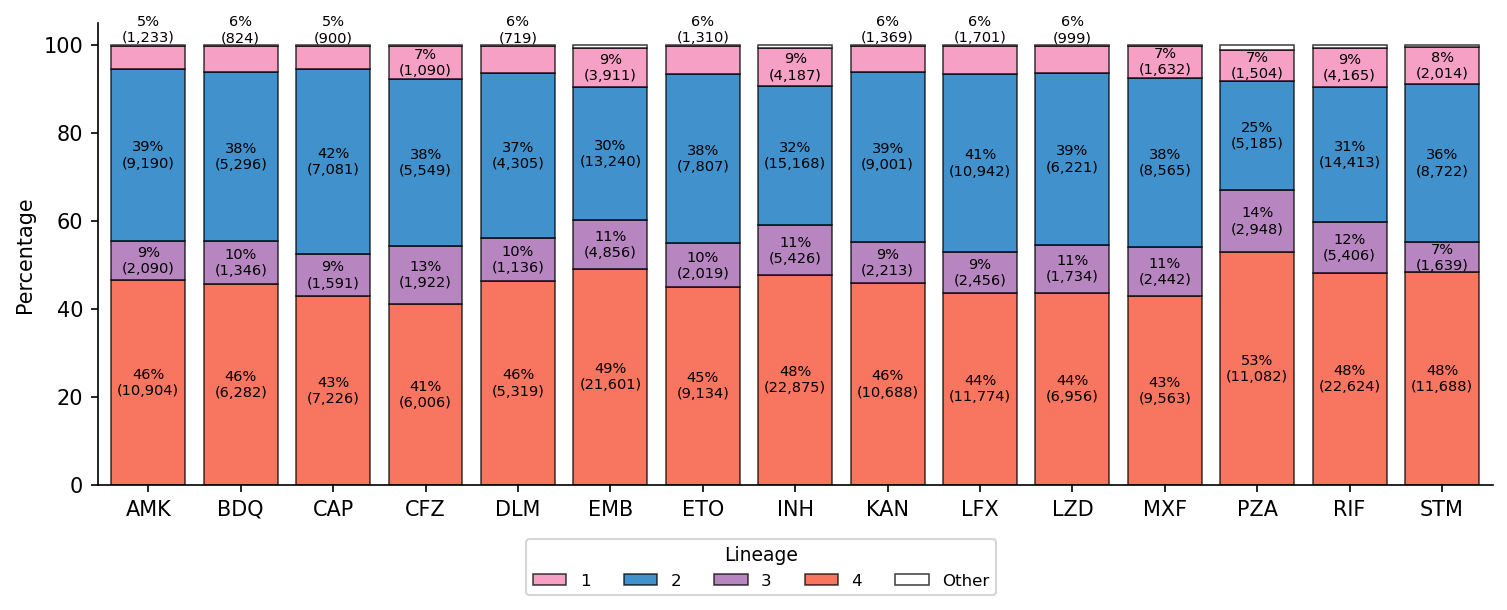

In [112]:
lineage_stacked_for_plotting = create_stacked_percent_bar_chart(single_drug_lineage_summary, "Drug", "Count", "Lineage", saveName="../results/Figures/isolates_by_lineage_stacked_bar.png")

# Overlap between WHO, ALL, and MIC datasets (WHO and MIC are disjoint)

In [2]:
samples_summary = samples_summary.set_index("Drug")
samples_summary.head()

,Genos,SNP_Matrix,ALL_Phenos,WHO_Phenos,ALL_Only,MIC,ALL_MIC,Tier1_LOF,Tier1_Inframe,Tier2_LOF,Tier2_Inframe
Drug,,,,,,,,,,,
Amikacin,24710,24710,24710,8958,15752,12639,9777,427,23,434.0,8.0
Bedaquiline,14135,14135,14135,2165,11970,12659,11231,801,18,72.0,127.0
Capreomycin,17716,17716,17716,10025,7691,1181,0,121,6,390.0,17.0
Clofazimine,14904,14904,14904,5027,9877,11406,9820,566,151,15.0,3.0
Delamanid,11803,11803,11803,575,11228,11341,11143,38,8,44.0,1.0


In [6]:
total_dict = {}

samples_summary_for_plotting = pd.DataFrame(columns = ['Drug', 'ALL_Phenos', 'WHO_Phenos', 'ALL_Only', 'MIC', 'MIC_Only', 'ALL_MIC', 'Total']).set_index('Drug')

for drug in drugs_lst:

    df_mic = pd.concat([pd.read_csv(fName) for fName in glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/mic/drug_name={drug}/*")])
    df_phenos = pd.concat([pd.read_csv(fName) for fName in glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue-raw-data/phenotypes/drug_name={drug}/*")])

    samples_summary_for_plotting.loc[drug, :] = [df_phenos.query("phenotypic_category in ['ALL', 'WHO']").sample_id.nunique(),
                                                df_phenos.query("phenotypic_category=='WHO'").sample_id.nunique(),
                                                df_phenos.query("phenotypic_category=='ALL'").sample_id.nunique(),
                                                df_mic.sample_id.nunique(),
                                                len(set(df_mic.sample_id) - set(df_phenos.sample_id)),
                                                df_phenos.query("phenotypic_category=='ALL' & box in ['CRyPTIC_MIC', 'MYCOTB_MIC']").sample_id.nunique(),
                                                 len(set(df_mic.sample_id).union(df_phenos.sample_id))
                                   ]

samples_summary_for_plotting = samples_summary_for_plotting.drop('Pretomanid')

samples_summary_for_plotting['ALL_not_MIC'] = samples_summary_for_plotting['ALL_Only'] - samples_summary_for_plotting['ALL_MIC']

del samples_summary_for_plotting['ALL_Phenos']
del samples_summary_for_plotting['MIC']
del samples_summary_for_plotting['ALL_Only']

# check that the computed Total is the sum as the number of unique samples from the dataframes
assert sum(samples_summary_for_plotting[samples_summary_for_plotting.columns[samples_summary_for_plotting.columns != 'Total']].sum(axis=1).values != samples_summary_for_plotting['Total']) == 0

# convert to percentages
samples_summary_for_plotting_percent = samples_summary_for_plotting.copy()

for col in samples_summary_for_plotting_percent.columns:

    if col != 'Total':
        samples_summary_for_plotting_percent[col] = samples_summary_for_plotting_percent[col] / samples_summary_for_plotting_percent['Total'] * 100

del samples_summary_for_plotting_percent['Total']

In [7]:
samples_summary_for_plotting_percent.MIC_Only.max()

0.6146850791512294

In [9]:
del samples_summary_for_plotting_percent['MIC_Only'] # makes up less than 1% of each dataset, so don't show.
del samples_summary_for_plotting['MIC_Only']

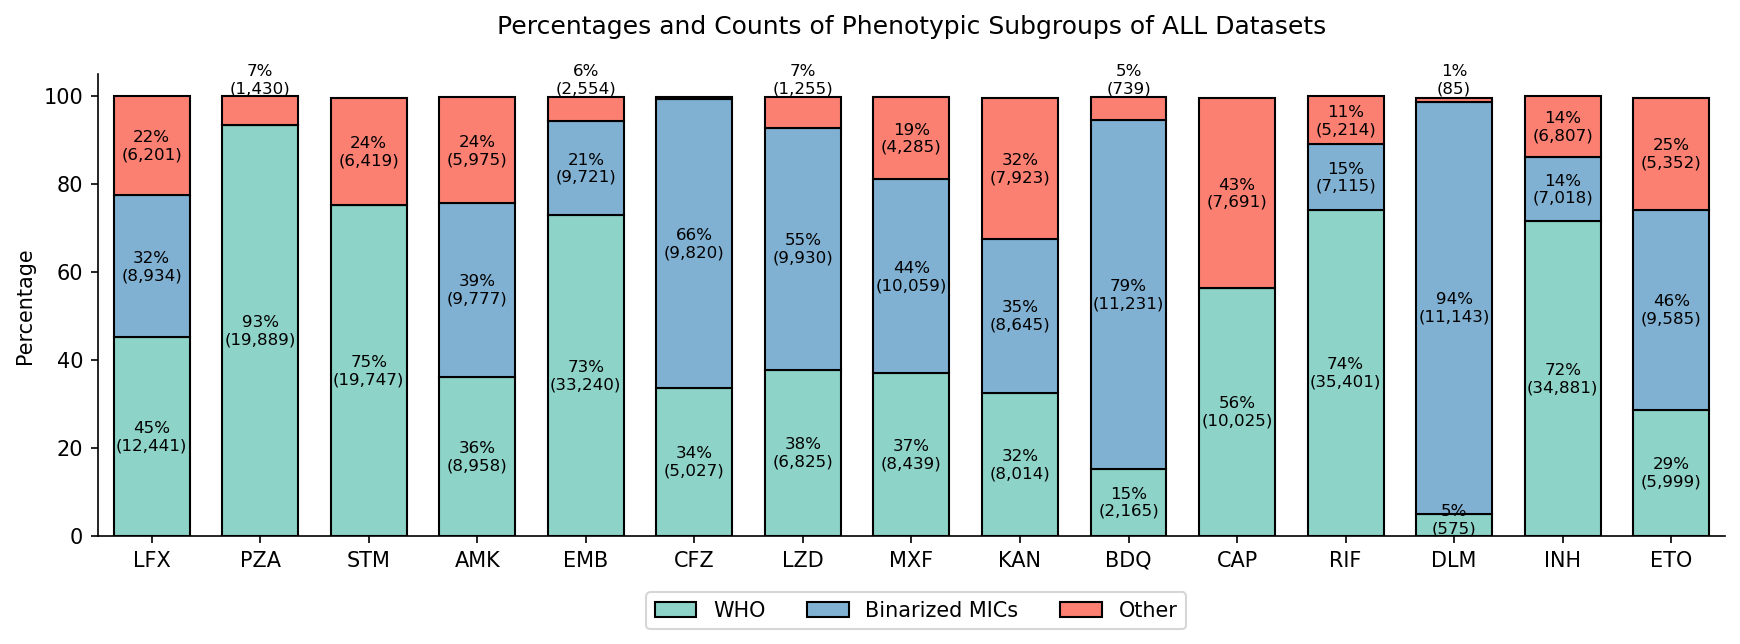

In [42]:
# Plotting
bar_width=0.7
fig, ax = plt.subplots(figsize=(14, 4))

# for 3 groups
colors = [sns.color_palette('Set3')[0]] + [sns.color_palette('Set3')[4]] + [sns.color_palette('Set3')[3]]
groups_dict = {'WHO_Phenos': 'WHO', 'ALL_MIC': 'Binarized MICs', 'ALL_not_MIC': 'Other', 'MIC_Only': 'MIC Only'}

prev_vals = np.zeros(samples_summary_for_plotting_percent.shape[0])

for i, group in enumerate(samples_summary_for_plotting_percent.columns):
    
    ax.bar([drug_abbr_dict[drug] for drug in samples_summary_for_plotting_percent.index.values], samples_summary_for_plotting_percent[group], width=bar_width, bottom=prev_vals, label=groups_dict[group], color=colors[i], edgecolor='black')

    prev_vals += samples_summary_for_plotting_percent[group]


for drug in samples_summary_for_plotting_percent.index.values:

    for col_idx, col in enumerate(samples_summary_for_plotting_percent.columns):

        val = int(np.round(samples_summary_for_plotting_percent.loc[drug, col], 0))

        # top of the current box
        y_upper = samples_summary_for_plotting_percent.loc[drug, samples_summary_for_plotting_percent.columns[:col_idx + 1]].values.sum()
        
        # bottom of the current box
        y_lower = samples_summary_for_plotting_percent.loc[drug, samples_summary_for_plotting_percent.columns[:col_idx]].values.sum()
        
        y_pos = np.mean([y_lower, y_upper])

        if val > 0:
            # format with commas and don't include any decimal places
            comma_format = '{:,.0f}'.format(samples_summary_for_plotting.loc[drug, col])
            combined_text = f"{val}%\n({comma_format})"

            # small numbers for which the bars are too short to accommodate the whole number, put on top
            if val < 10:

                # top bar: make y_pos = 100
                if col_idx == samples_summary_for_plotting_percent.shape[1] - 1:
                    ax.text(drug_abbr_dict[drug], 100, combined_text, ha='center', va='bottom', fontsize='8')
                # bottom bar: make y_pos = 0
                elif col_idx == 0:
                    ax.text(drug_abbr_dict[drug], 0, combined_text, ha='center', va='bottom', fontsize='8')
                # else, idk
                else:
                    ax.text(drug_abbr_dict[drug], y_pos, combined_text, ha='center', va='bottom', fontsize='8')
            else:
                ax.text(drug_abbr_dict[drug], y_pos, combined_text, ha='center', va='center', fontsize='8')


ax.margins(x=0.01)
ax.set_ylabel("Percentage")
plt.title("Percentages and Counts of Phenotypic Subgroups of ALL Datasets\n")
sns.despine()
plt.legend()

sns.move_legend(ax, fontsize=10, title='', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                ncol=len(colors),
               bbox_to_anchor=(0.675, -0.1))

plt.savefig("../results/Figures/phenotypic_subgroups.png", bbox_inches='tight', dpi=300)

# Bedaquiline Skew between WHO and ALL Datasets

In [342]:
drug = "Bedaquiline"
df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
df_phenos = df_phenos.merge(lineages, left_on='sample_id', right_on='Sample_ID', how='left')

who_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
all_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=ALL/dropAF_noSyn_unpooled/model_matrix.pkl"))

df_WHO = df_phenos.query("sample_id in @who_model_matrix.index.values & ~Lineage.str.contains(',')")
df_ALL = df_phenos.query("sample_id in @all_model_matrix.index.values & ~Lineage.str.contains(',')")
print(len(df_WHO), len(df_ALL))

2003 13776


In [343]:
df_WHO_lineage_phenos = pd.DataFrame(df_WHO.groupby("Lineage").phenotype.mean()).reset_index()
df_WHO_lineage_phenos.loc[-1, :] = ['Total', df_WHO.phenotype.mean()]
df_WHO_lineage_phenos['Dataset'] = 'WHO'

df_ALL_lineage_phenos = pd.DataFrame(df_ALL.groupby("Lineage").phenotype.mean()).reset_index()
df_ALL_lineage_phenos.loc[-1, :] = ['Total', df_ALL.phenotype.mean()]
df_ALL_lineage_phenos['Dataset'] = 'ALL'

lineage_phenos_combined = pd.concat([df_WHO_lineage_phenos, df_ALL_lineage_phenos])
lineage_phenos_combined['phenotype'] *= 100
print(len(set(df_WHO.sample_id).intersection(df_ALL.sample_id)))

2002


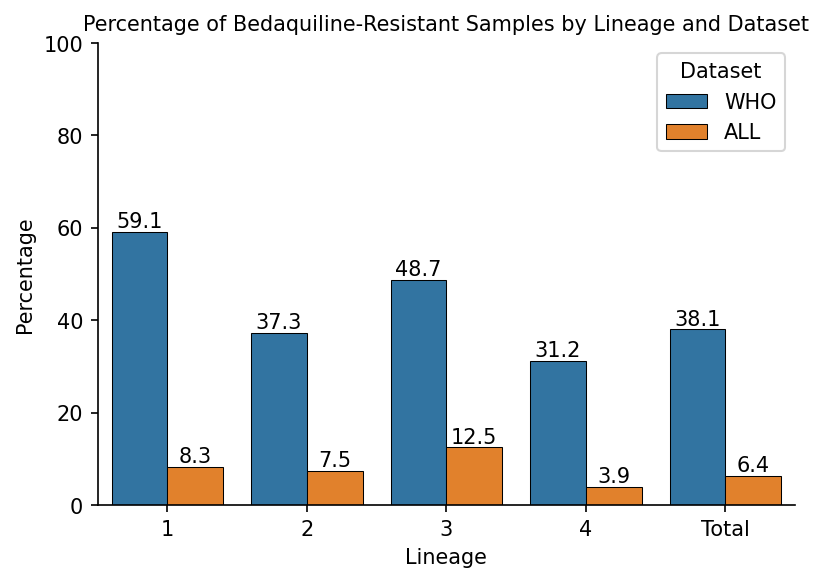

In [346]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(data=lineage_phenos_combined.query("phenotype > 0"),
            x='Lineage',
            y='phenotype',
            hue='Dataset',
            edgecolor='black',
            linewidth=0.5,
            ax=ax
           )

for container in ax.containers:
    ax.bar_label(container, fmt='{:.1f}')

plt.ylabel("Percentage")
plt.title("Percentage of Bedaquiline-Resistant Samples by Lineage and Dataset", size=10)
plt.ylim(0, 100)
sns.despine()
plt.savefig("../results/Figures/BDQ_phenos_by_lineage_dataset.png", dpi=300, bbox_inches='tight')

In [383]:
mic_model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl"))
df_mic = pd.read_csv(os.path.join(analysis_dir, 'Bedaquiline', "phenos_mic.csv"))

# first apply the media hierarchy to decide which of the measured MICs to keep for each isolate (for isolates with multiple MICs measured in different media)
df_mic = process_multiple_MICs_different_media(df_mic)

# then normalize the MICs to the most common medium. This creates a new column: norm_MIC that should be used if not Pretomanid
pheno_col = 'norm_MIC'
df_mic, most_common_medium = normalize_MICs_return_dataframe(drug, df_mic, cc_df)
print(f"    Min MIC: {np.min(df_mic[pheno_col].values)}, Max MIC: {np.max(df_mic[pheno_col].values)} in {most_common_medium}")

mic_model_matrix = mic_model_matrix.merge(df_mic, left_index=True, right_on='sample_id', how='left')

    Dropped 58/12646 isolates in ['7H10', '7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'M24 BMD'] without critical concentrations
    Min MIC: 0.00375, Max MIC: 2.0 in UKMYC5


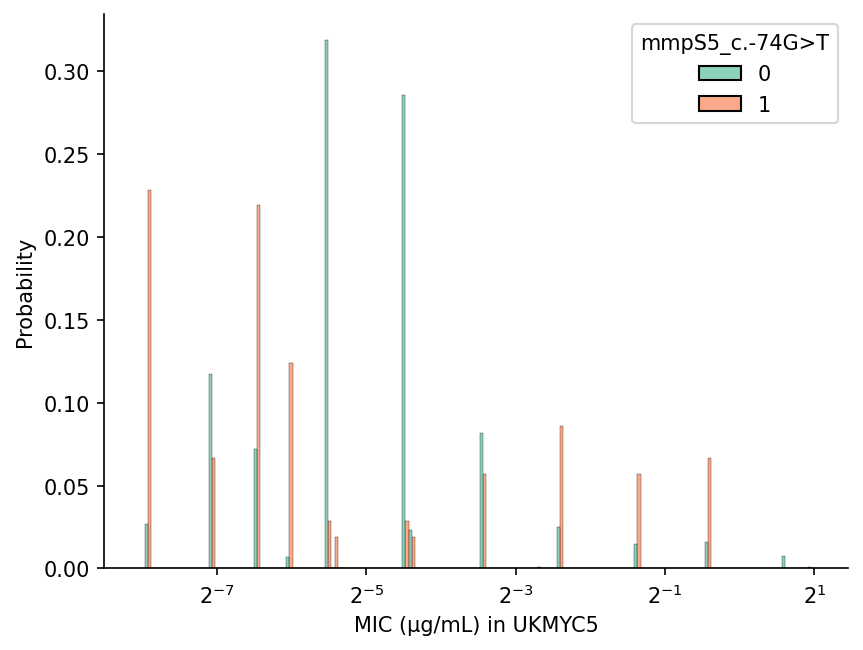

In [385]:
mic_model_matrix['mmpS5_c.-74G>T'] = mic_model_matrix['mmpS5_c.-74G>T'].astype(int)

sns.histplot(data=mic_model_matrix,
             x='norm_MIC',
             log_scale=2,
             hue='mmpS5_c.-74G>T',
             palette='Set2',
             common_norm=False,
             multiple='dodge',
             stat='probability',
            )

plt.xlabel(f'MIC (µg/mL) in {most_common_medium}')
sns.despine()
plt.savefig("../results/Figures/Bedaquiline_MICs_mmpS5.png", bbox_inches='tight', dpi=300)

In [386]:
len(mic_model_matrix)

12379

In [387]:
mic_model_matrix.loc[mic_model_matrix['mmpS5_c.-74G>T']==1]

,Rv0678_p.Ala101Glu,Rv0678_p.Ala102Thr,Rv0678_p.Ala110Val,Rv0678_p.Ala110fs,Rv0678_p.Ala112Pro,Rv0678_p.Ala112Ser,Rv0678_p.Ala36Val,Rv0678_p.Ala59Val,Rv0678_p.Ala62Thr,Rv0678_p.Ala62fs,...,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC
582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,830,MGIT,0.0000,0.125,(,],0.06250,1.00,UKMYC5,0.015625
223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,837,MGIT,0.0625,0.125,(,],0.09375,1.00,UKMYC5,0.023438
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,840,MGIT,0.0625,0.125,(,],0.09375,1.00,UKMYC5,0.023438
848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,841,MGIT,0.1250,0.250,(,],0.18750,1.00,UKMYC5,0.046875
6093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6871,UKMYC6,0.0080,0.015,(,],0.01150,0.25,UKMYC5,0.011500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,823381,MGIT,0.1250,0.250,(,],0.18750,1.00,UKMYC5,0.046875
927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,823384,MGIT,2.0000,4.000,(,],3.00000,1.00,UKMYC5,0.750000
1143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,823403,MGIT,2.0000,4.000,(,],3.00000,1.00,UKMYC5,0.750000
1227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,823455,MGIT,0.2500,0.500,(,],0.37500,1.00,UKMYC5,0.093750


# S95T Distribution Across MXF and LXF Isolates

In [117]:
def get_all_data_single_drug(drug):

    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_genos = pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])
    
    df_genos['mutation'] = df_genos['resolved_symbol'] + '_' + df_genos['variant_category']
    del df_genos['resolved_symbol']
    del df_genos['variant_category']

    df_MIC = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))
    pheno_col = "norm_MIC"
    
    # first apply the media hierarchy to decide which of the measured MICs to keep for each isolate (for isolates with multiple MICs measured in different media)
    df_MIC = process_multiple_MICs_different_media(df_MIC)
    
    # then normalize the MICs to the most common medium. This creates a new column: norm_MIC that should be used if not Pretomanid
    df_MIC, most_common_medium = normalize_MICs_return_dataframe(drug, df_MIC, cc_df)
    print(f"    Min MIC: {np.min(df_MIC[pheno_col].values)}, Max MIC: {np.max(df_MIC[pheno_col].values)} in {most_common_medium}")

    return df_phenos, df_genos, df_MIC

In [118]:
MXF_phenos, MXF_genos, MXF_MIC = get_all_data_single_drug('Moxifloxacin')
LEV_phenos, LEV_genos, LEV_MIC = get_all_data_single_drug('Levofloxacin')

    Dropped 97/12740 isolates in ['7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'REMA', 'M24 BMD'] without critical concentrations
    Min MIC: 0.03, Max MIC: 20.0 in UKMYC5
    Dropped 60/11434 isolates in ['7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'M24 BMD'] without critical concentrations
    Min MIC: 0.06, Max MIC: 8.0 in UKMYC5


In [134]:
def get_data_isolates_with_without_variant(variant, df_genos):

    isolates_with_var = df_genos.query("mutation==@variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_without_var = list(set(df_genos.sample_id) - set(isolates_with_var))
    
    print(f"{len(isolates_with_var)} isolates with {variant}, {len(isolates_without_var)} isolates without it")

    isolates_with_other_vars = df_genos.query("sample_id in @isolates_with_var & mutation != @variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_with_no_other_vars = list(set(isolates_with_var) - set(isolates_with_other_vars))
    
    # check that the only variant in these isolates is S95T
    assert len(df_genos.query("sample_id in @isolates_with_no_other_vars & variant_allele_frequency > 0.75").mutation.unique()) == 1
    assert df_genos.query("sample_id in @isolates_with_no_other_vars & variant_allele_frequency > 0.75").mutation.unique()[0] == variant
    
    isolates_with_something = df_genos.query("sample_id in @isolates_without_var & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_with_nothing = list(set(isolates_without_var) - set(isolates_with_something))
    
    # check that there are no variants in these isolates
    assert len(df_genos.query("sample_id in @isolates_with_nothing & variant_allele_frequency > 0.75")) == 0
    
    print(f"{len(isolates_with_no_other_vars)} isolates with only {variant}, {len(isolates_with_nothing)} isolates with no variants at all\n")

    # add in lineage information to plot distribution of isolates across lineages, stratified by presence/absence of the variant
    df_with_lineages = lineages.query("Sample_ID in @isolates_with_no_other_vars")[['Sample_ID', 'Coll2014', 'Lineage']]
    df_with_lineages[variant] = 1
    
    df_with_lineages = pd.concat([df_with_lineages, lineages.query("Sample_ID in @isolates_with_nothing")[['Sample_ID', 'Coll2014', 'Lineage']]])
    df_with_lineages[variant] = df_with_lineages[variant].fillna(0).astype(int)

    # exclude isolates with multiple lineages
    df_1 = lineages.query("Sample_ID in @isolates_with_no_other_vars & ~Lineage.str.contains(',')")[['Sample_ID', 'Lineage']].groupby("Lineage")['Sample_ID'].count().reset_index().rename(columns={'Sample_ID': 'Count'})
    df_1[variant] = 1
    
    df_2 = lineages.query("Sample_ID in @isolates_with_nothing & ~Lineage.str.contains(',')")[['Sample_ID', 'Lineage']].groupby("Lineage")['Sample_ID'].count().reset_index().rename(columns={'Sample_ID': 'Count'})
    df_2[variant] = 0
    
    df_lineages_summary = pd.concat([df_1, df_2])
    
    # make sure all lineages are there for both groups. If not, fill with 0s
    for lineage in df_lineages_summary.Lineage.unique():
    
        if len(df_lineages_summary.loc[df_lineages_summary[variant]==1].query("Lineage==@lineage")) == 0:
            df_lineages_summary = pd.concat([df_lineages_summary, pd.DataFrame({'Lineage': lineage, 'Count': 0, variant: 1}, index=[-1])])
    
        if len(df_lineages_summary.loc[df_lineages_summary[variant]==0].query("Lineage==@lineage")) == 0:
            df_lineages_summary = pd.concat([df_lineages_summary, pd.DataFrame({'Lineage': lineage, 'Count': 0, variant: 0}, index=[-1])])
    
    df_lineages_summary = df_lineages_summary.reset_index(drop=True)
    
    df_lineages_summary['Lineage_Total'] = df_lineages_summary['Lineage'].map(dict(df_lineages_summary.groupby('Lineage')['Count'].sum()))
    df_lineages_summary['Lineage_Percentage'] = df_lineages_summary['Count'] / df_lineages_summary['Lineage_Total'] * 100
    
    df_lineages_summary['Var_Total'] = df_lineages_summary[variant].map(dict(df_lineages_summary.groupby(variant)['Count'].sum()))
    df_lineages_summary['Var_Percentage'] = df_lineages_summary['Count'] / df_lineages_summary['Var_Total'] * 100
    
    df_lineages_summary = df_lineages_summary.sort_values([variant, "Lineage"], ascending=[True, False])
    return df_lineages_summary

In [135]:
variant = 'gyrA_p.Ser95Thr'
MXF_lineages_summary = get_data_isolates_with_without_variant(variant, MXF_genos)
LEV_lineages_summary = get_data_isolates_with_without_variant(variant, LEV_genos)

20903 isolates with gyrA_p.Ser95Thr, 1880 isolates without it
17 isolates with only gyrA_p.Ser95Thr, 37 isolates with no variants at all

24965 isolates with gyrA_p.Ser95Thr, 2611 isolates without it
23 isolates with only gyrA_p.Ser95Thr, 44 isolates with no variants at all



In [241]:
def plot_lineage_distribution_by_variant(variant, df_lineages_summary, drug, save=False):

    fig, ax = plt.subplots(figsize=(3.5, 5))
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "6": "#36ba74",
                       "7": "#ffb000",
                       "BOV": "gray",
                       "BOV_AFRI": "black",
                      }
    
    #lineages_lst = np.sort(MXF_lineages_summary.Lineage.unique())
    groups = [f'- {variant}', f'+ {variant}']

    lineages_lst = df_lineages_summary.Lineage.unique()
    df_lineages_summary = df_lineages_summary.set_index('Lineage')
    
    group_totals = np.zeros(len(groups))
    
    for i, lineage in enumerate(lineages_lst):
    
        ax.bar(groups, 
               height=df_lineages_summary.loc[lineage, 'Var_Percentage'], 
               bottom=group_totals, 
               color=LinToColor_Dict[lineage], 
               edgecolor='black', 
               # linewidth=0.5, 
               label=lineage, 
               alpha=0.75
              )
    
        group_totals += df_lineages_summary.loc[lineage, 'Var_Percentage'].values
    
        # ax.bar_label(container=ax.containers[i], labels=[np.round(val.get_height(), 1) if val.get_height() > 0 else "" for val in ax.containers[i]], fmt='{:.1f}', label_type='center', fontsize='11')
    
        # annotate with percentage and counts
        for group in [0, 1]:

            val = int(np.round(df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineage, 'Var_Percentage'], 0))

            if val > 0:
                # bottom of the current box
                y_upper = df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineages_lst[:i+1], 'Var_Percentage'].values.sum()
                y_lower = df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineages_lst[:i], 'Var_Percentage'].values.sum()
    
                y_pos = np.mean([y_lower, y_upper])
            
                # format the isolate counts with commas and don't include any decimal places
                var_lineage_count = '{:,.0f}'.format(df_lineages_summary.loc[df_lineages_summary[variant]==group].loc[lineage, 'Count'])
                combined_text = f"{val}% ({var_lineage_count})"
                ax.text(group, y_pos, combined_text, ha='center', va='center', fontsize='9')
        
    bar_scale = 0.8
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
    
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = current_width * bar_scale
        # Adjusting the x coordinate to center the bar
        diff_width = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff_width / 2)
    
    plt.setp(ax.patches, linewidth=0.75)
    plt.legend()
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))
    
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    
    sns.move_legend(ax, 
                    ncols=len(lineages_lst), 
                    fontsize=7, title='Lineage', loc='best', 
                    bbox_to_anchor=(0.86, -0.08)
                   )
    plt.xlabel('')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('Percentage')
    plt.title(f'Lineage Distribution of {df_lineages_summary.Count.sum()} {drug} Samples\n')
    
    sns.despine()

    if not save:
        plt.show()
    else:
        plt.savefig(f"../results/Figures/{drug}_MICs_S95T_lineage.png", dpi=300, bbox_inches='tight')

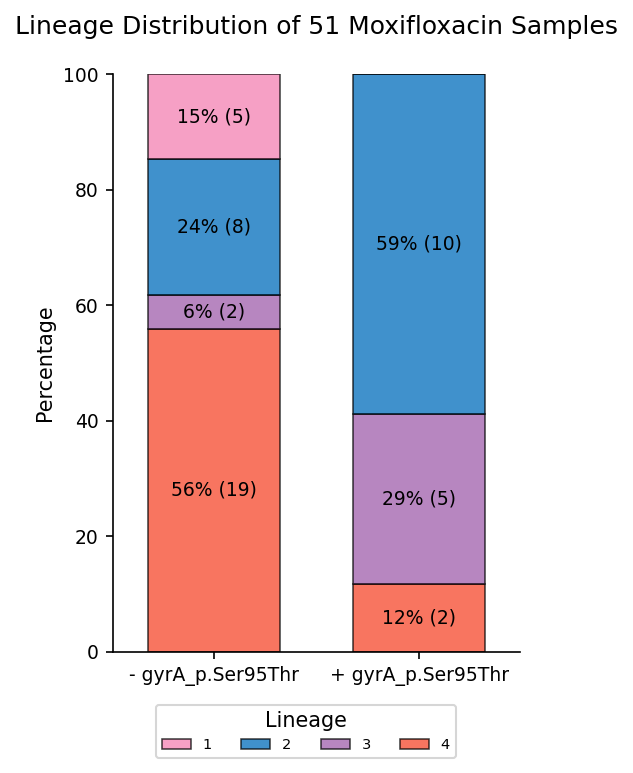

In [242]:
plot_lineage_distribution_by_variant(variant, MXF_lineages_summary, 'Moxifloxacin', save=True)

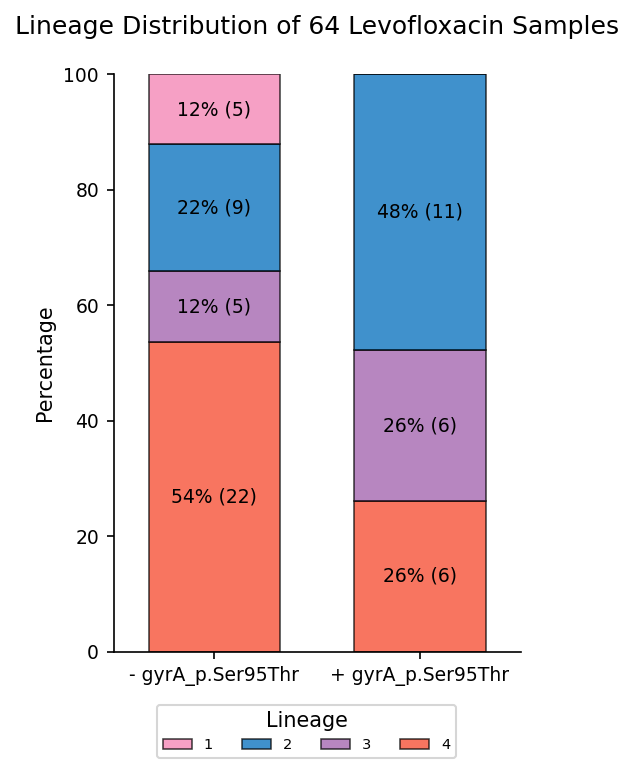

In [243]:
plot_lineage_distribution_by_variant(variant, LEV_lineages_summary, 'Levofloxacin', save=True)

In [236]:
def plot_MIC_ECDF_by_variant(variant, df_genos, df_MIC, drug, save=False):

    isolates_with_var = df_genos.query("mutation==@variant & variant_allele_frequency > 0.75").sample_id.unique()
    isolates_without_var = list(set(df_genos.sample_id) - set(isolates_with_var))
    
    print(f"{len(isolates_with_var)} isolates with {variant}, {len(isolates_without_var)} isolates without it")

    df_MIC.loc[df_MIC['sample_id'].isin(isolates_with_var), variant] = 1
    df_MIC.loc[df_MIC['sample_id'].isin(isolates_without_var), variant] = 0
    
    assert len(df_MIC.loc[pd.isnull(df_MIC[variant])]) == 0
    df_MIC[variant] = df_MIC[variant].astype(int)
    df_MIC.groupby(variant)['norm_MIC'].mean()

    fig, ax = plt.subplots()
    
    sns.ecdfplot(data=df_MIC,
                 x='norm_MIC',
                 hue=variant,
                 log_scale=2,
                 palette='Set2',
                 ax=ax
                )
    
    plt.title(f"{len(df_MIC)} {drug} MICs")
    plt.xlabel(f"MIC (µg/mL) in UKMYC5")

    plt.ylabel("Percentile")
    plt.yticks(ticks=ax.get_yticks(), labels=(ax.get_yticks()*100).astype(int))
    sns.move_legend(ax, loc='lower right')
    
    sns.despine()
    
    if not save:
        plt.show()
    else:
        plt.savefig(f"../results/Figures/{drug}_MICs_S95T.png", dpi=300, bbox_inches='tight')

20903 isolates with gyrA_p.Ser95Thr, 1880 isolates without it


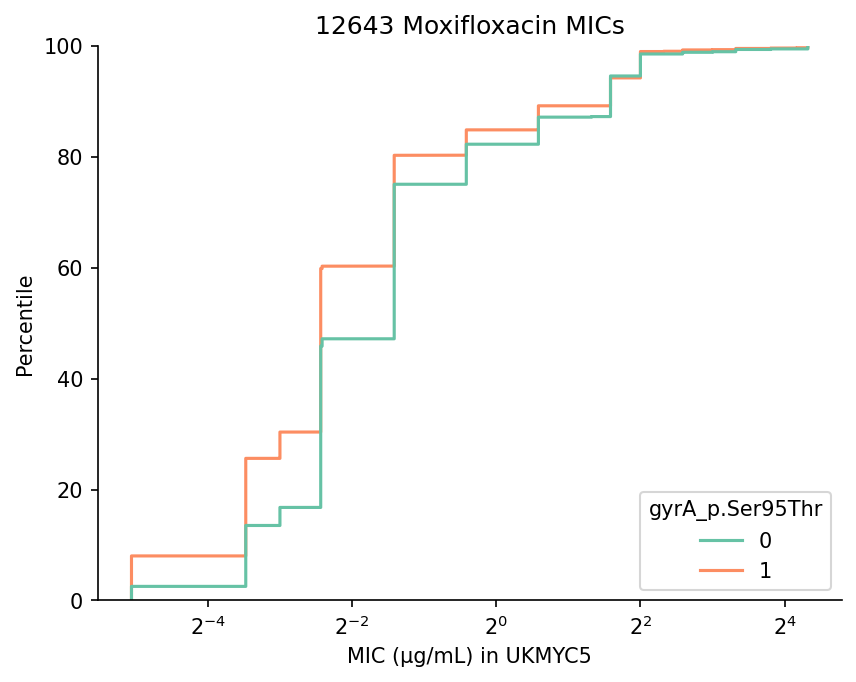

In [237]:
plot_MIC_ECDF_by_variant(variant, MXF_genos, MXF_MIC, 'Moxifloxacin', save=True)

24965 isolates with gyrA_p.Ser95Thr, 2611 isolates without it


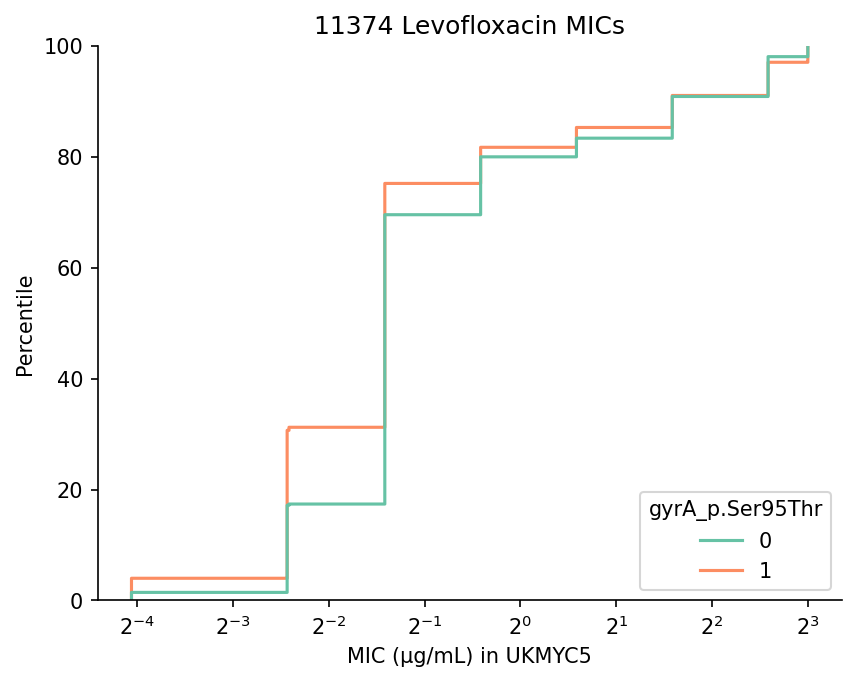

In [238]:
plot_MIC_ECDF_by_variant(variant, LEV_genos, LEV_MIC, 'Levofloxacin', save=True)